In [1]:
# from statsmodels.stats import outliers_influence

In [2]:
from scipy.spatial.distance import euclidean, minkowski, chebyshev, cosine

In [3]:
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm

In [5]:
import pandas as pd

In [6]:
import seaborn as sns

In [7]:
import numpy as np

In [8]:
import missingno

In [9]:
df = pd.read_excel("ACS Data Color Coding.xlsx",
                   sheet_name='acs2015_census_tract_data')

### Made sense to set the CensusTract as the Index

In [10]:
df.set_index('CensusTract', inplace=True)

### Snapshot of the original data

In [11]:
df.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusTract,,,,,,,,,,,,,,,,,,,,,
1001020100,Alabama,Autauga,1948,940,1008,0.9,87.4,7.7,0.3,0.6,...,0.5,2.3,2.1,25.0,943,77.1,18.3,4.6,0.0,5.4
1001020200,Alabama,Autauga,2156,1059,1097,0.8,40.4,53.3,0.0,2.3,...,0.0,0.7,0.0,23.4,753,77.0,16.9,6.1,0.0,13.3
1001020300,Alabama,Autauga,2968,1364,1604,0.0,74.5,18.6,0.5,1.4,...,0.0,0.0,2.5,19.6,1373,64.1,23.6,12.3,0.0,6.2
1001020400,Alabama,Autauga,4423,2172,2251,10.5,82.8,3.7,1.6,0.0,...,0.0,2.6,1.6,25.3,1782,75.7,21.2,3.1,0.0,10.8
1001020500,Alabama,Autauga,10763,4922,5841,0.7,68.5,24.8,0.0,3.8,...,0.0,0.6,0.9,24.8,5037,67.1,27.6,5.3,0.0,4.2


### 74001 rows
- minimum of 72901 non-null values
- 36 columns
- mostly numeric except State and County (can be part of multi-index)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74001 entries, 1001020100 to 72153750602
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   State            74001 non-null  object 
 1   County           74001 non-null  object 
 2   TotalPop         74001 non-null  int64  
 3   Men              74001 non-null  int64  
 4   Women            74001 non-null  int64  
 5   Hispanic         73311 non-null  float64
 6   White            73311 non-null  float64
 7   Black            73311 non-null  float64
 8   Native           73311 non-null  float64
 9   Asian            73311 non-null  float64
 10  Pacific          73311 non-null  float64
 11  Citizen          74001 non-null  int64  
 12  Income           72901 non-null  float64
 13  IncomeErr        72901 non-null  float64
 14  IncomePerCap     73261 non-null  float64
 15  IncomePerCapErr  73261 non-null  float64
 16  Poverty          73166 non-null  float64
 1

### White lines in the following graphic show the missing values by row
### If many white lines in 1 row, many values are missing for that row

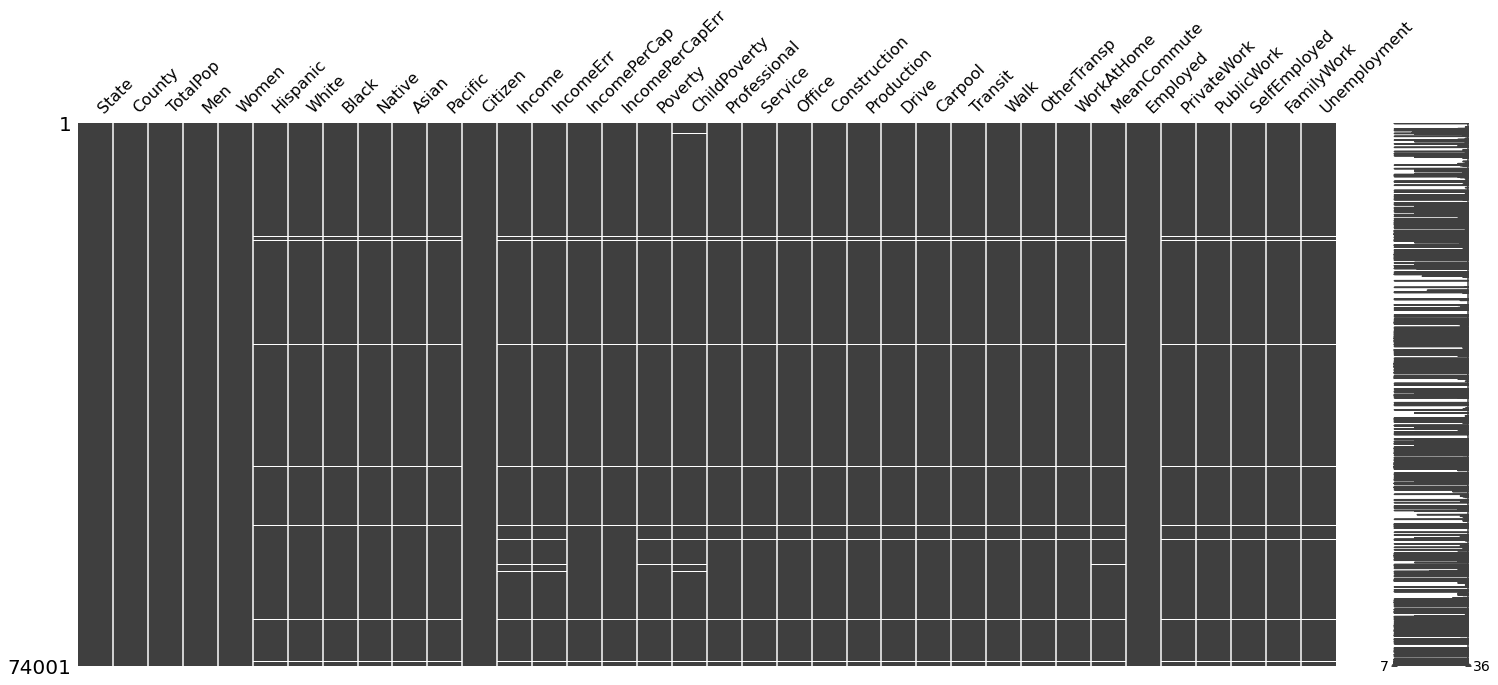

In [13]:
missingno.matrix(df);

### Shows the same point as the previous graphic
"if a missing value occurs in an attribute, how likely is a missing value in this other attribute"

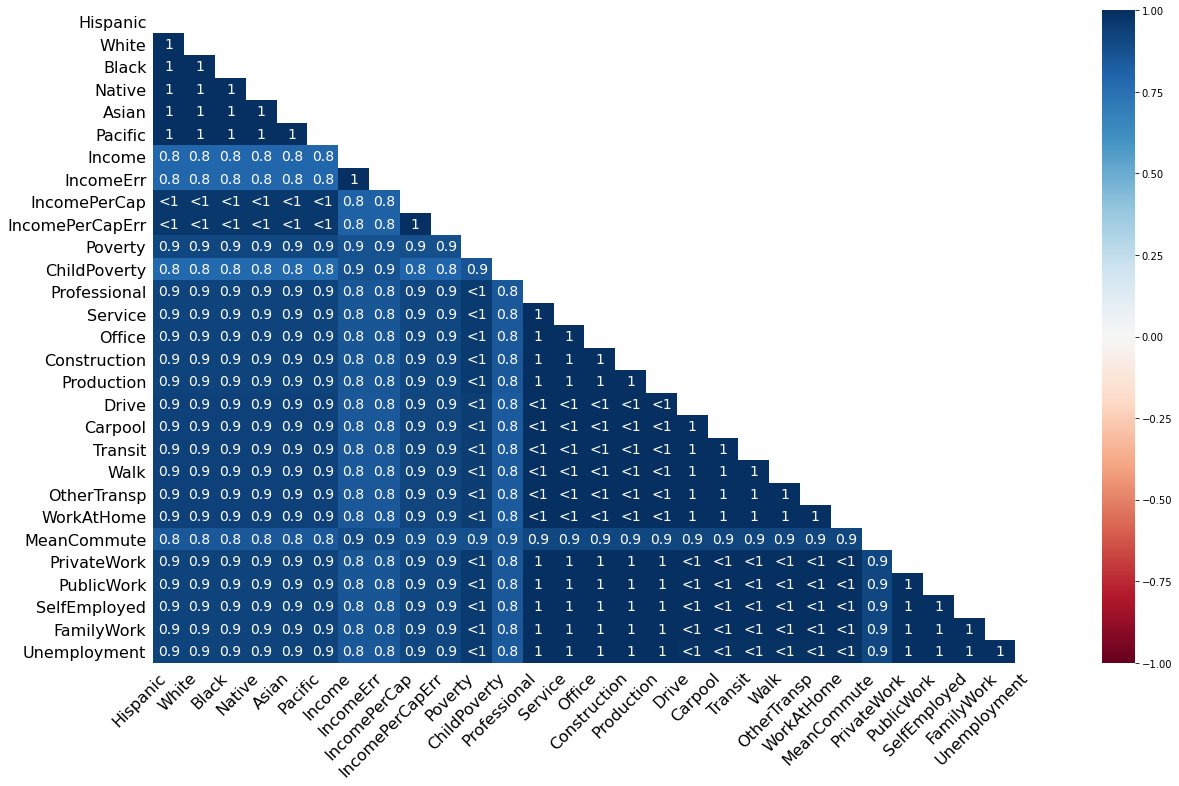

In [14]:
missingno.heatmap(df);

In [15]:
df[['Income','Poverty','IncomePerCap','ChildPoverty','Unemployment']].corr()

,Income,Poverty,IncomePerCap,ChildPoverty,Unemployment
Income,1.000000,-0.702208,0.834342,-0.663684,-0.483252
Poverty,-0.702208,1.000000,-0.606543,0.897260,0.637417
IncomePerCap,0.834342,-0.606543,1.000000,-0.585279,-0.463069
ChildPoverty,-0.663684,0.897260,-0.585279,1.000000,0.598072
Unemployment,-0.483252,0.637417,-0.463069,0.598072,1.000000


### Many missing values for Income come from Metropolitan areas

In [16]:
df.loc[df['Income'].isna(), ['State','County']].value_counts().nlargest(15)

State          County      
California     Los Angeles     41
New York       Queens          27
Hawaii         Hawaii          17
Florida        Miami-Dade      14
Arizona        Maricopa        13
New York       Kings           13
               New York        13
Puerto Rico    San Juan        13
Hawaii         Honolulu        13
Pennsylvania   Allegheny       12
Florida        Hillsborough    12
Massachusetts  Suffolk         12
Michigan       Wayne           10
Pennsylvania   Philadelphia    10
New York       Bronx           10
dtype: int64

### Given rows with missing Income values, what percent of the other data is missing
(Page 88)
- We could use regression to estimate the Income of the census tract (Option 6) --laborious
- Or we could use the median of the county (Option 5) --df.groupby(['State','County']).median()
- Or just drop them (Option 1) --Filtering by Southeast region does this

In [17]:
df.loc[df['Income'].isna()].isnull().mean().sort_values(ascending=False)

Income             1.000000
IncomeErr          1.000000
ChildPoverty       0.877273
MeanCommute        0.830909
Poverty            0.759091
Professional       0.731818
FamilyWork         0.731818
SelfEmployed       0.731818
PublicWork         0.731818
PrivateWork        0.731818
Production         0.731818
Construction       0.731818
Office             0.731818
Service            0.731818
Unemployment       0.728182
Transit            0.722727
Drive              0.722727
WorkAtHome         0.722727
OtherTransp        0.722727
Walk               0.722727
Carpool            0.722727
IncomePerCap       0.672727
IncomePerCapErr    0.672727
Black              0.627273
Native             0.627273
Asian              0.627273
Pacific            0.627273
White              0.627273
Hispanic           0.627273
County             0.000000
Citizen            0.000000
Employed           0.000000
Women              0.000000
Men                0.000000
TotalPop           0.000000
State              0

In [18]:
df.groupby(['State','County']).median()

TotalPop     Men   Women  Hispanic  White  Black  Native  \
State   County                                                                 
Alabama Autauga       3290.5  1703.0  1657.0      0.85  74.50  15.35    0.00   
        Baldwin       5567.5  2660.5  2766.0      4.30  85.60   5.40    0.20   
        Barbour       3524.0  1663.0  1214.0      4.20  48.60  47.00    0.00   
        Bibb          5679.5  2701.5  2960.5      2.45  81.75  12.85    0.25   
        Blount        7007.0  3412.0  3273.0      8.10  88.20   0.40    0.10   
...                      ...     ...     ...       ...    ...    ...     ...   
Wyoming Sweetwater    3472.5  1808.5  1641.0     13.60  84.60   0.25    0.00   
        Teton         5964.5  3147.5  2776.5     17.45  80.75   0.15    0.25   
        Uinta         7081.0  3437.0  3277.0      6.30  87.70   0.20    0.10   
        Washakie      2578.0  1265.0  1314.0     12.30  84.70   0.00    0.30   
        Weston        3576.0  1847.5  1728.5      3.20  92.25   0.20    0.70   

                    Asian  Pacific  Citizen  ...  Walk  OtherTransp  \
State   County                               ...                      
Alabama Autauga      0.00      0.0   2556.0  ...  0.00         0.95   
        Baldwin      0.20      0.0   4273.0  ...  0.80         1.10   
        Barbour      0.00      0.0   2659.0  ...  1.70         1.40   
        Bibb         0.05      0.0   4152.0  ...  0.55         1.65   
        Blount       0.10      0.0   4999.0  ...  0.20         0.50   
...                   ...      ...      ...  ...   ...          ...   
Wyoming Sweetwater   0.50      0.0   2462.0  ...  2.15         0.95   
        Teton        0.65      0.0   4493.5  ...  9.75         4.85   
        Uinta        0.00      0.0   4759.0  ...  2.70         1.50   
        Washakie     0.00      0.0   1888.0  ...  7.00         3.90   
        Weston       0.55      0.0   2791.0  ...  3.40         1.20   

                    WorkAtHome  MeanCommute  Employed  PrivateWork  \
State   County                                                       
Alabama Autauga           1.85        24.90    1521.5        76.95   
        Baldwin           3.30        26.00    2264.5        80.60   
        Barbour           1.40        22.10     876.0        72.30   
        Bibb              0.75        31.75    2169.0        78.35   
        Blount            2.10        35.60    2352.0        81.90   
...                        ...          ...       ...          ...   
Wyoming Sweetwater        1.35        21.60    1691.0        78.80   
        Teton             5.15        13.80    3657.5        81.90   
        Uinta             3.50        17.70    3292.0        76.60   
        Washakie          2.00        12.60    1188.0        70.90   
        Weston            5.50        28.90    1671.5        70.20   

                    PublicWork  SelfEmployed  FamilyWork  Unemployment  
State   County                                                          
Alabama Autauga          18.90          4.95         0.0          7.75  
        Baldwin          11.50          6.40         0.0          7.70  
        Barbour          21.90          5.50         0.0         13.40  
        Bibb             15.45          6.45         0.0          9.90  
        Blount           14.20          3.80         0.0          7.50  
...                        ...           ...         ...           ...  
Wyoming Sweetwater       17.05          4.10         0.0          4.80  
        Teton             9.95          7.05         0.0          2.60  
        Uinta            19.80          5.60         0.0          3.70  
        Washakie         21.90          7.70         0.0          6.70  
        Weston           20.20          8.35         1.3          5.20  

[3220 rows x 34 columns]

In [19]:
df.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,74001.000000,74001.000000,74001.000000,73311.000000,73311.000000,73311.000000,73311.000000,73311.000000,73311.000000,74001.000000,...,73204.000000,73204.000000,73204.000000,73052.000000,74001.000000,73194.000000,73194.000000,73194.000000,73194.000000,73199.000000
mean,4325.591465,2127.648816,2197.942649,16.862810,62.032106,13.272581,0.727726,4.588253,0.145012,3043.079566,...,3.123340,1.891606,4.368093,25.667357,1983.907366,78.975238,14.621566,6.233814,0.169772,9.028663
std,2129.306903,1072.332031,1095.730931,22.940695,30.684152,21.762483,4.488340,8.794003,1.037354,1475.492946,...,5.881237,2.596198,3.904990,6.964881,1073.429808,8.345758,7.535786,4.042990,0.458227,5.955441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2891.000000,1409.000000,1461.000000,2.400000,39.400000,0.700000,0.000000,0.200000,0.000000,2037.000000,...,0.400000,0.400000,1.800000,20.800000,1249.000000,74.600000,9.600000,3.500000,0.000000,5.100000
50%,4063.000000,1986.000000,2066.000000,7.000000,71.400000,3.700000,0.000000,1.400000,0.000000,2863.000000,...,1.400000,1.100000,3.500000,25.000000,1846.000000,80.100000,13.400000,5.500000,0.000000,7.700000
75%,5442.000000,2674.000000,2774.000000,20.400000,88.300000,14.400000,0.400000,4.800000,0.000000,3838.000000,...,3.500000,2.500000,5.900000,29.800000,2553.000000,84.600000,18.200000,8.100000,0.000000,11.400000
max,53812.000000,27962.000000,27250.000000,100.000000,100.000000,100.000000,100.000000,91.300000,84.700000,37416.000000,...,100.000000,100.000000,100.000000,80.000000,24075.000000,100.000000,100.000000,100.000000,26.500000,100.000000


### Now let's look at the similarity between our numeric attributes

In [20]:
similarity_df = df.select_dtypes(np.number).dropna(how='any', axis=0)

In [21]:
euclidean_df = pd.DataFrame(columns=['Attr1','Attr2','Distance'])
for col in similarity_df:
    for col2 in similarity_df:
        euclidean_df = euclidean_df.append({'Attr1':col,
                                            'Attr2':col2,
                                            'Distance':euclidean(similarity_df[col], similarity_df[col2])}, 
                                           ignore_index=True)

In [22]:
mask = np.zeros_like(euclidean_df.pivot("Attr1","Attr2","Distance"))
mask[np.triu_indices_from(mask)] = True

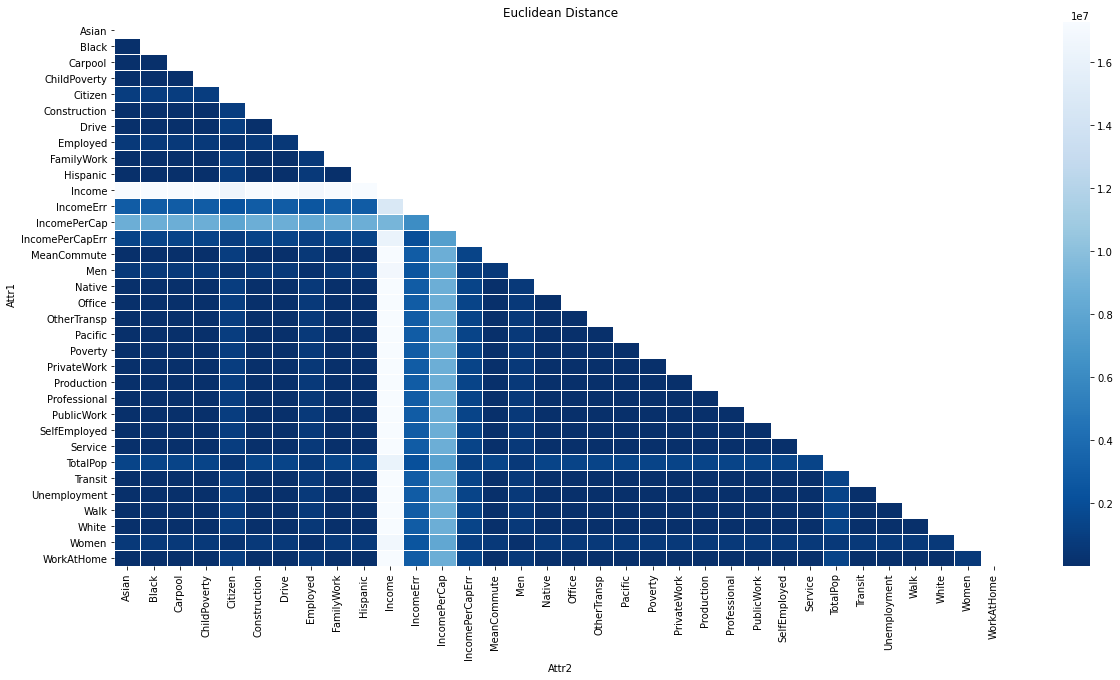

In [23]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.heatmap(euclidean_df.pivot("Attr1","Attr2","Distance"), cmap='Blues_r', mask=mask, linewidths=.5,linecolor='white')
ax.set_title("Euclidean Distance");

In [24]:
euclidean_df.loc[euclidean_df['Distance']!=0].sort_values(by='Distance',ascending=True)

,Attr1,Attr2,Distance
1096,FamilyWork,Pacific,3.028420e+02
304,Pacific,FamilyWork,3.028420e+02
1113,FamilyWork,OtherTransp,8.287806e+02
882,OtherTransp,FamilyWork,8.287806e+02
297,Pacific,OtherTransp,8.567069e+02
...,...,...,...
346,Income,Native,1.726824e+07
1098,FamilyWork,Income,1.726833e+07
372,Income,FamilyWork,1.726833e+07
282,Pacific,Income,1.726834e+07


In [25]:
minkowski_df = pd.DataFrame(columns=['Attr1','Attr2','Distance'])
for col in similarity_df:
    for col2 in similarity_df:
        minkowski_df = minkowski_df.append({'Attr1':col,
                                            'Attr2':col2,
                                            'Distance':minkowski(similarity_df[col], similarity_df[col2])}, 
                                           ignore_index=True)

In [26]:
mask = np.zeros_like(minkowski_df.pivot("Attr1","Attr2","Distance"))
mask[np.triu_indices_from(mask)] = True

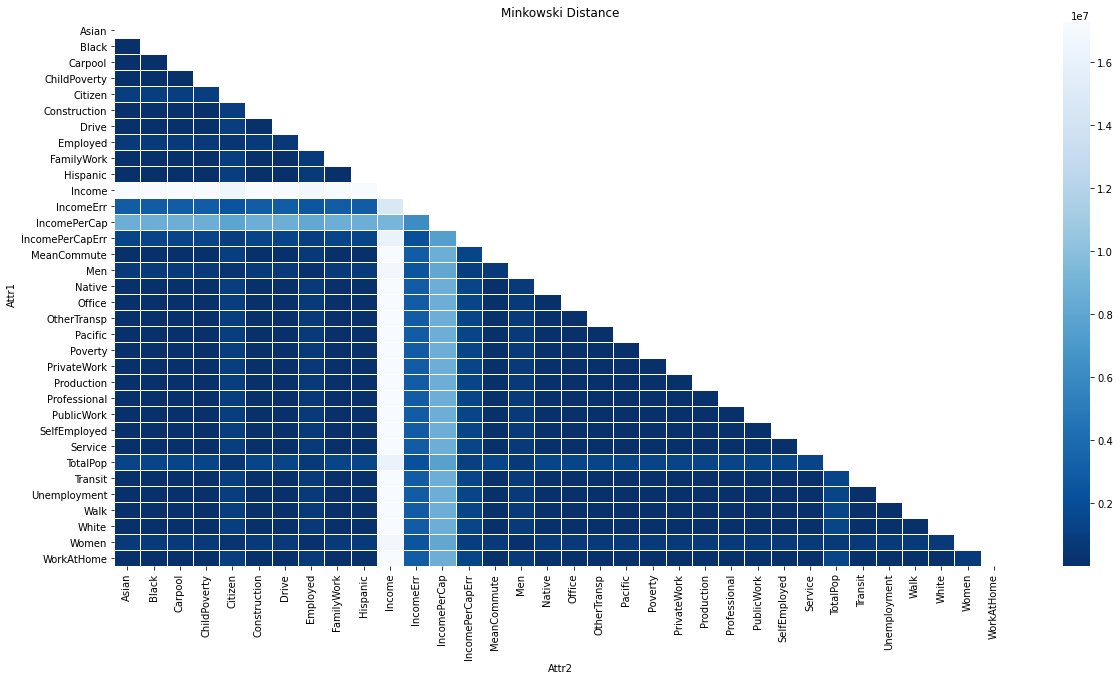

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.heatmap(minkowski_df.pivot("Attr1","Attr2","Distance"), cmap='Blues_r', mask=mask, linewidths=.5,linecolor='white')
ax.set_title("Minkowski Distance");

In [28]:
minkowski_df.loc[minkowski_df['Distance']!=0].sort_values(by='Distance',ascending=True)

,Attr1,Attr2,Distance
1096,FamilyWork,Pacific,3.028420e+02
304,Pacific,FamilyWork,3.028420e+02
1113,FamilyWork,OtherTransp,8.287806e+02
882,OtherTransp,FamilyWork,8.287806e+02
297,Pacific,OtherTransp,8.567069e+02
...,...,...,...
346,Income,Native,1.726824e+07
1098,FamilyWork,Income,1.726833e+07
372,Income,FamilyWork,1.726833e+07
282,Pacific,Income,1.726834e+07


In [29]:
chebyshev_df = pd.DataFrame(columns=['Attr1','Attr2','Distance']).astype('float64')
for col in similarity_df:
    for col2 in similarity_df:
        chebyshev_df = chebyshev_df.append({'Attr1':col,
                                            'Attr2':col2,
                                            'Distance':chebyshev(similarity_df[col], similarity_df[col2])}, 
                                           ignore_index=True)

In [30]:
mask = np.zeros_like(chebyshev_df.pivot("Attr1","Attr2","Distance"))

In [31]:
mask[np.triu_indices_from(mask)] = True

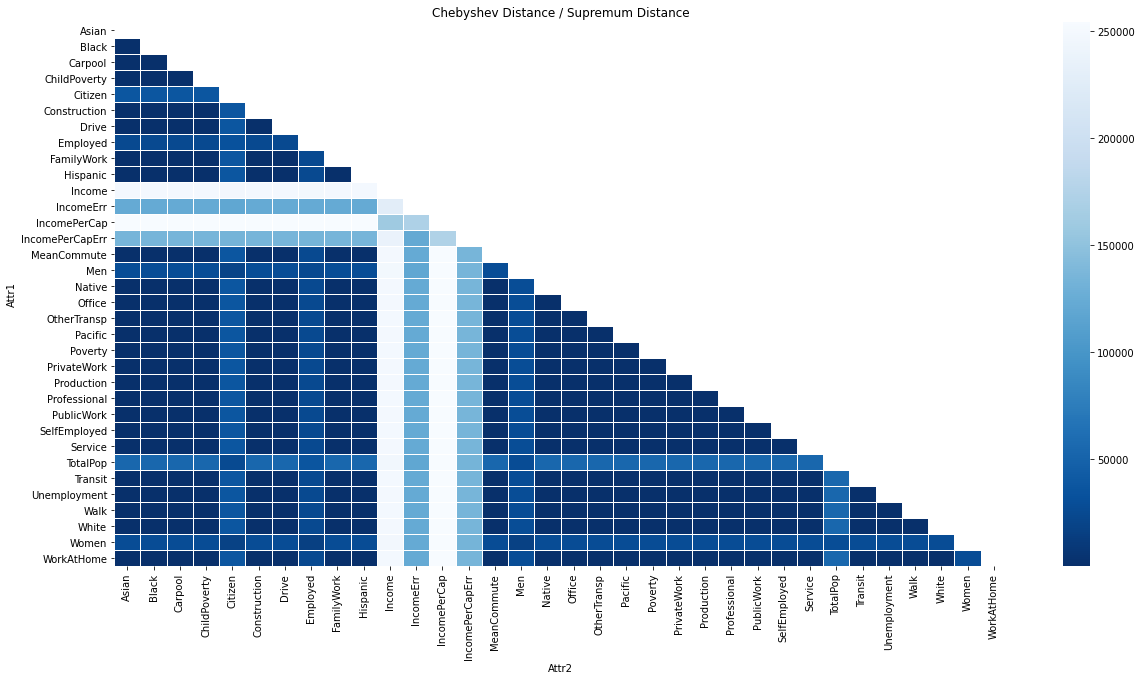

In [32]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.heatmap(chebyshev_df.pivot("Attr1","Attr2","Distance"), cmap='Blues_r', mask=mask, linewidths=.5,linecolor='white')
ax.set_title("Chebyshev Distance / Supremum Distance");

In [33]:
chebyshev_df.loc[chebyshev_df['Distance']!=0].sort_values(by='Distance',ascending=True)

,Attr1,Attr2,Distance
1119,FamilyWork,SelfEmployed,48.6
1086,SelfEmployed,FamilyWork,48.6
768,Carpool,Production,50.7
702,Production,Carpool,50.7
779,Carpool,SelfEmployed,51.6
...,...,...,...
590,Service,IncomePerCap,254204.0
428,IncomePerCap,Production,254204.0
414,IncomePerCap,Native,254204.0
1134,Unemployment,IncomePerCap,254204.0


In [34]:
cosine_df = pd.DataFrame(columns=['Attr1','Attr2','Distance']).astype('float64')
for col in similarity_df:
    for col2 in similarity_df:
        cosine_df = cosine_df.append({'Attr1':col,
                                            'Attr2':col2,
                                            'Distance':cosine(similarity_df[col], similarity_df[col2])}, 
                                           ignore_index=True)

In [35]:
mask = np.zeros_like(cosine_df.pivot("Attr1","Attr2","Distance"))

In [36]:
mask[np.triu_indices_from(mask)] = True

### Reversed the colors for Cosine similarity. Closer to 1 is more similar.

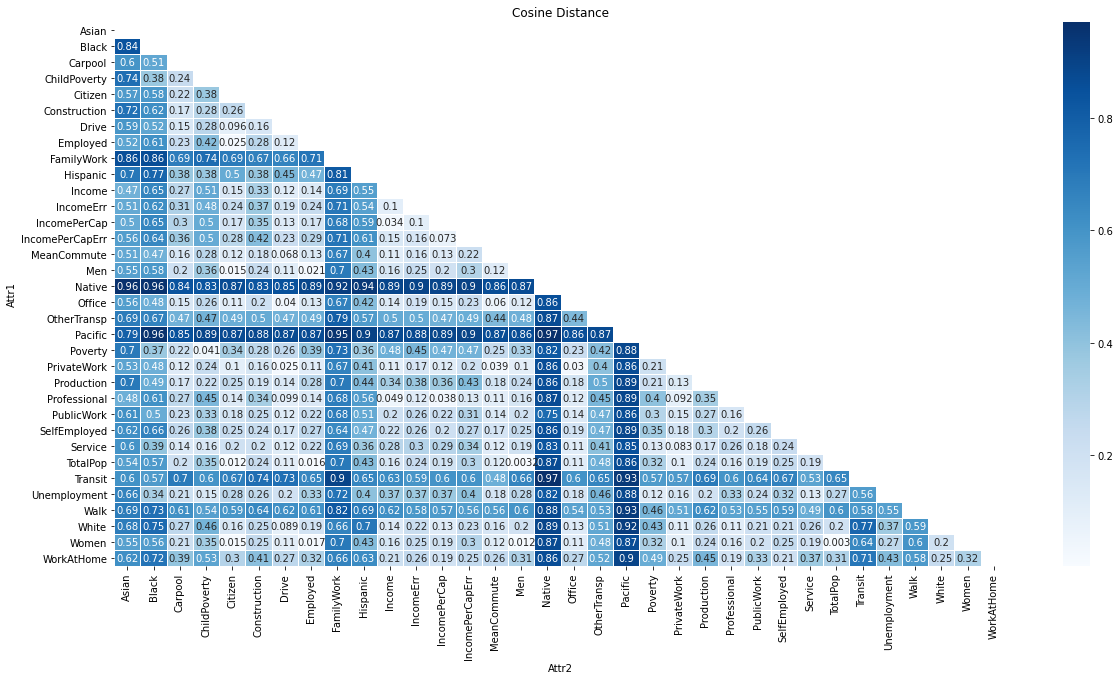

In [37]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.heatmap(cosine_df.pivot("Attr1","Attr2","Distance"), cmap='Blues', mask=mask, linewidths=.5,linecolor='white', annot=True)
ax.set_title("Cosine Distance");

In [38]:
cosine_df.loc[cosine_df['Distance']!=0].sort_values(by='Distance',ascending=False)

,Attr1,Attr2,Distance
227,Native,Transit,0.969532
788,Transit,Native,0.969532
278,Pacific,Native,0.969299
212,Native,Pacific,0.969299
244,Asian,Native,0.962124
...,...,...,...
9,TotalPop,Citizen,0.012098
34,Men,TotalPop,0.003196
1,TotalPop,Men,0.003196
68,Women,TotalPop,0.002997


### Over 3,000 counties if we want to combine census tracts
(It's best not to use Nearest Neighbors algorithms without location data.)

In [39]:
len(df.groupby(['State','County']).groups.keys())

3220

### Example County data

In [40]:
df.groupby(['State','County']).get_group(('Florida','Escambia'))

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusTract,,,,,,,,,,,,,,,,,,,,,
12033000100,Florida,Escambia,1429,707,722,1.5,52.3,35.1,0.3,3.1,...,2.9,8.2,1.5,16.6,748,81.1,13.6,5.2,0.0,13.3
12033000300,Florida,Escambia,2129,1170,959,6.5,53.1,34.2,0.2,0.0,...,0.0,3.9,6.0,23.2,1124,80.6,12.3,7.1,0.0,4.8
12033000400,Florida,Escambia,3394,1366,2028,2.9,12.9,82.9,0.0,0.3,...,0.9,0.0,8.4,19.9,1095,81.3,11.1,7.6,0.0,18.2
12033000500,Florida,Escambia,1376,636,740,1.7,64.4,30.8,0.0,0.9,...,0.5,0.9,12.3,15.4,650,76.2,13.5,9.4,0.9,6.3
12033000600,Florida,Escambia,1630,677,953,1.2,19.1,79.5,0.1,0.0,...,0.0,3.6,1.3,18.3,673,70.9,20.8,8.3,0.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033003700,Florida,Escambia,4169,2081,2088,2.6,71.1,22.0,0.4,0.6,...,0.0,0.8,2.0,22.4,1786,82.3,14.8,3.0,0.0,7.6
12033003800,Florida,Escambia,4570,2385,2185,2.0,82.6,8.4,1.1,0.4,...,0.5,1.6,5.4,26.7,2101,71.3,15.0,13.3,0.4,9.0
12033003900,Florida,Escambia,4223,1835,2388,6.0,78.3,7.2,0.8,1.3,...,1.2,0.7,7.7,32.2,1776,72.8,16.8,10.4,0.0,6.1


### The following are just the descriptions of the attributes

In [41]:
df.loc[:,:'Citizen'].describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen
count,74001.000000,74001.000000,74001.000000,73311.000000,73311.000000,73311.000000,73311.000000,73311.000000,73311.000000,74001.000000
mean,4325.591465,2127.648816,2197.942649,16.862810,62.032106,13.272581,0.727726,4.588253,0.145012,3043.079566
std,2129.306903,1072.332031,1095.730931,22.940695,30.684152,21.762483,4.488340,8.794003,1.037354,1475.492946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2891.000000,1409.000000,1461.000000,2.400000,39.400000,0.700000,0.000000,0.200000,0.000000,2037.000000
50%,4063.000000,1986.000000,2066.000000,7.000000,71.400000,3.700000,0.000000,1.400000,0.000000,2863.000000
75%,5442.000000,2674.000000,2774.000000,20.400000,88.300000,14.400000,0.400000,4.800000,0.000000,3838.000000
max,53812.000000,27962.000000,27250.000000,100.000000,100.000000,100.000000,100.000000,91.300000,84.700000,37416.000000


In [42]:
df.loc[:,'Income':'Office'].describe()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office
count,72901.000000,72901.000000,73261.000000,73261.000000,73166.000000,72883.000000,73194.000000,73194.000000,73194.000000
mean,57225.564862,9134.493848,28491.234299,3942.909229,16.958020,22.486827,34.798843,19.101381,23.951559
std,28663.331962,5920.336551,15047.068660,3023.027898,13.196518,19.190909,15.007075,8.279143,5.957279
min,2611.000000,390.000000,128.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37683.000000,5317.000000,19123.000000,2312.000000,7.200000,7.000000,24.100000,13.400000,20.100000
50%,51094.000000,7732.000000,25344.000000,3127.000000,13.400000,17.800000,32.600000,17.900000,23.800000
75%,70117.000000,11258.000000,33894.000000,4537.000000,23.100000,33.800000,43.875000,23.600000,27.500000
max,248750.000000,123116.000000,254204.000000,134380.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [43]:
df.loc[:,'Construction':'Employed'].describe()

,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed
count,73194.000000,73194.000000,73204.000000,73204.000000,73204.000000,73204.000000,73204.000000,73204.000000,73052.000000,74001.000000
mean,9.292337,12.856005,75.533887,9.627468,5.456050,3.123340,1.891606,4.368093,25.667357,1983.907366
std,6.023290,7.671588,15.371620,5.367321,11.724287,5.881237,2.596198,3.904990,6.964881,1073.429808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,0.000000
25%,5.000000,7.100000,72.000000,6.000000,0.000000,0.400000,0.400000,1.800000,20.800000,1249.000000
50%,8.400000,11.800000,79.700000,8.800000,1.100000,1.400000,1.100000,3.500000,25.000000,1846.000000
75%,12.500000,17.400000,84.900000,12.300000,4.700000,3.500000,2.500000,5.900000,29.800000,2553.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,80.000000,24075.000000


In [44]:
df.loc[:,'PrivateWork':].describe()

,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,73194.000000,73194.000000,73194.000000,73194.000000,73199.000000
mean,78.975238,14.621566,6.233814,0.169772,9.028663
std,8.345758,7.535786,4.042990,0.458227,5.955441
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.600000,9.600000,3.500000,0.000000,5.100000
50%,80.100000,13.400000,5.500000,0.000000,7.700000
75%,84.600000,18.200000,8.100000,0.000000,11.400000
max,100.000000,100.000000,100.000000,26.500000,100.000000


### Noticed these 4 combine to near 100%

In [45]:
(df['PrivateWork'] + df['PublicWork'] + df['SelfEmployed'] + df['FamilyWork']).describe()

count    73194.000000
mean       100.000391
std          0.051625
min         99.900000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.200000
dtype: float64

### Just decimal scaling like (3.12)

In [46]:
df['Hispanic']     = df['Hispanic'] / 100
df['White']        = df['White'] / 100
df['Black']        = df['Black'] / 100
df['Native']       = df['Native'] / 100
df['Asian']        = df['Asian'] / 100
df['Pacific']      = df['Pacific'] / 100
df['Poverty']      = df['Poverty'] / 100
df['ChildPoverty'] = df['ChildPoverty'] / 100
df['Professional'] = df['Professional'] / 100
df['Service']      = df['Service'] / 100
df['Office']       = df['Office'] / 100
df['Construction'] = df['Construction'] / 100
df['Production']   = df['Production'] / 100
df['Drive']        = df['Drive'] / 100
df['Carpool']      = df['Carpool'] / 100
df['Transit']      = df['Transit'] / 100
df['Walk']         = df['Walk'] / 100
df['OtherTransp']  = df['OtherTransp'] / 100
df['WorkAtHome']   = df['WorkAtHome'] / 100
df['PrivateWork']  = df['PrivateWork'] / 100
df['PublicWork']   = df['PublicWork'] / 100
df['SelfEmployed'] = df['SelfEmployed'] / 100
df['FamilyWork']   = df['FamilyWork'] / 100
df['Unemployment']   = df['Unemployment'] / 100

## Ideas for Attribute Reduction (by Esteban):
### 36 original attributes
1. Drop race demographic data: Hispanic, White, Black, Native, Asian, Pacific (36 - 6 = 30)
2. Drop sex demographic data: Men, Women (30 - 2 = 28)
3. Drop Income derivative data: IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty (28 - 5 = 23)
4. Drop TotalPop derivative data: Citizen, Unemployment, <strike>Employment</strike>, PrivateWork, PublicWork, SelfEmployed, FamilyWork (23 - 5 = 18)
5. Combine transportation: Car vs Other (18 + 2 - 6 = 14)
6. Drop MeanCommute (14 - 1 = 13)

## Ideas for Attribute Reduction (by Nick):
1. Use demographic data: County, State, TotalPop, Men, Women, White, Minority (Non-white), Income, IncomePerCap, Poverty, ChildPoverty

### From here, we should convert all percentages to real figures before we filter down to the Southeast region <br />(to get down to 550 <= rows <=1500)

## We decided to go with Nick's suggestion for attribute reduction

In [47]:
df['Minority'] = df['Hispanic'] + df['Black'] + df['Native'] + df['Asian'] + df['Pacific']

In [48]:
df = df[['County','State','TotalPop','Men','Women', 'White','Minority','Income','IncomePerCap','Poverty','ChildPoverty']]

### As stated before, we must convert percentages into real figures in order to aggregate by County

In [49]:
df['White'] = df['White'] * df['TotalPop']
df['Minority'] = df['Minority'] * df['TotalPop']
df['Poverty'] = df['Poverty'] * df['TotalPop']
df['ChildPoverty'] = df['ChildPoverty'] * df['TotalPop']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74001 entries, 1001020100 to 72153750602
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   County        74001 non-null  object 
 1   State         74001 non-null  object 
 2   TotalPop      74001 non-null  int64  
 3   Men           74001 non-null  int64  
 4   Women         74001 non-null  int64  
 5   White         73311 non-null  float64
 6   Minority      73311 non-null  float64
 7   Income        72901 non-null  float64
 8   IncomePerCap  73261 non-null  float64
 9   Poverty       73166 non-null  float64
 10  ChildPoverty  72883 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 6.8+ MB


### Filter by Southeast region to reduce our row count from 3220 to 1023
### Because we aggregate by county, all null values for CensusTract are rolled up as 0's

In [51]:
df = df.groupby(['State','County']).agg({'TotalPop':[np.sum],
                                         'Men':[np.sum],
                                         'Women':[np.sum],
                                         'White':[np.sum],
                                         'Minority':[np.sum],
                                         'Income':[np.mean],
                                         'IncomePerCap':[np.mean],
                                         'Poverty':[np.sum],
                                         'ChildPoverty':[np.sum]}).loc[["Alabama",
                                                                        "Arkansas",
                                                                        "Florida",
                                                                        "Georgia",
                                                                        "Kentucky",
                                                                        "Maryland",
                                                                        "Mississippi",
                                                                        "North Carolina",
                                                                        "South Carolina",
                                                                        "Tennessee",
                                                                        "Virginia",
                                                                        "West Virginia"],:]

In [52]:
df.head()

TotalPop    Men  Women       White   Minority        Income  \
                     sum    sum    sum         sum        sum          mean   
State   County                                                                
Alabama Autauga    55221  26745  28476   41851.017  12445.085  49985.000000   
        Baldwin   195121  95314  99807  162150.656  29686.216  48672.838710   
        Barbour    26932  14497  12435   12451.093  13989.509  32367.666667   
        Bibb       22604  12073  10531   16839.955   5462.476  40211.500000   
        Blount     57710  28512  29198   50700.459   6114.227  45101.111111   

                 IncomePerCap    Poverty ChildPoverty  
                         mean        sum          sum  
State   County                                         
Alabama Autauga  24386.916667   7130.304    10330.513  
        Baldwin  26842.774194  26193.492    38017.971  
        Barbour  17104.555556   7138.496    11731.477  
        Bibb     18807.000000   3753.111     6147.629  
        Blount   20171.333333   9649.988    15499.392

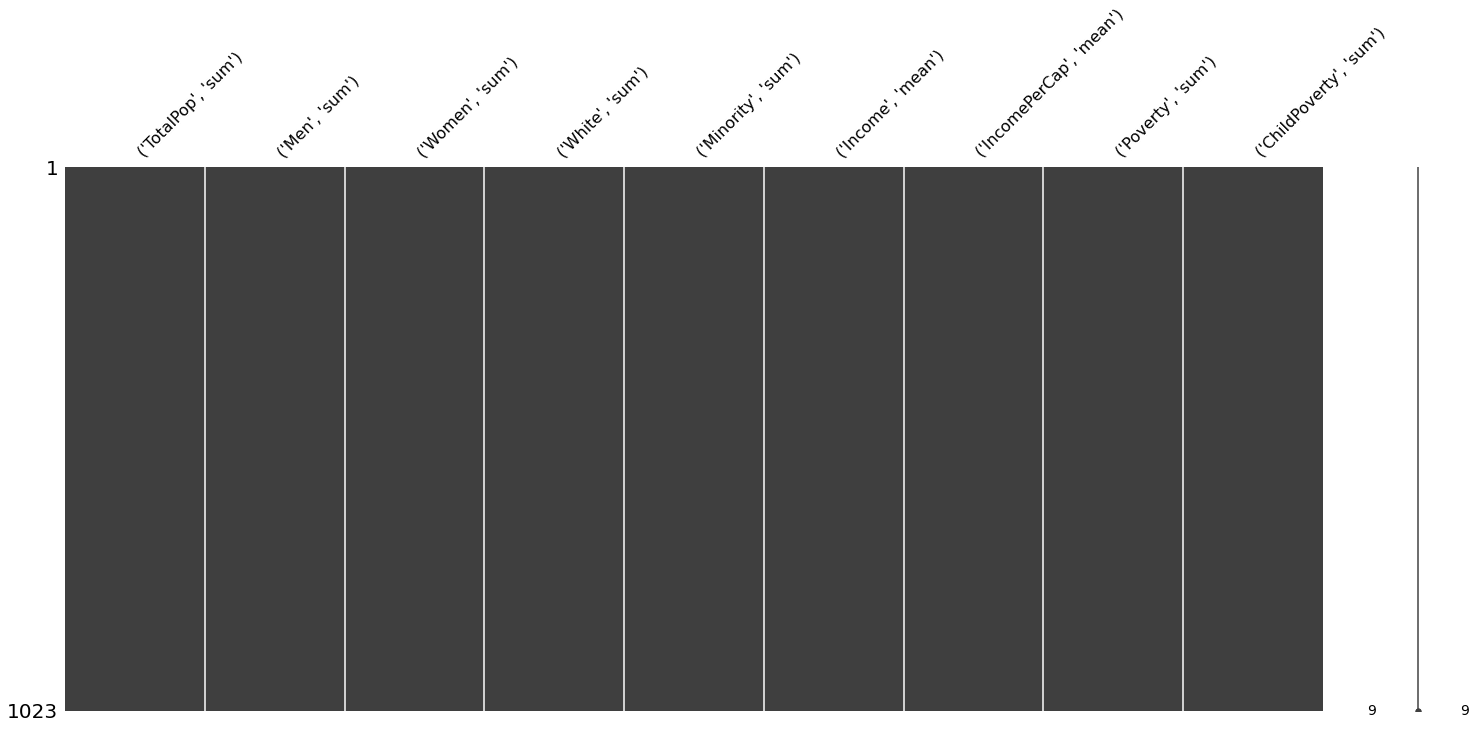

In [53]:
missingno.matrix(df);

In [54]:
df['Men']    =df['Men']/ df['TotalPop']
df['Women']  =df['Women']/ df['TotalPop']
df['White']  =df['White']/ df['TotalPop']
df['Minority'] =df['Minority']/df['TotalPop']
df['Poverty']=df['Poverty']/df['TotalPop']
df['ChildPoverty']=df['ChildPoverty']/df['TotalPop']

In [55]:
df.head()

TotalPop       Men     Women     White  Minority  \
                     sum       sum       sum       sum       sum   
State   County                                                     
Alabama Autauga    55221  0.484327  0.515673  0.757882  0.225369   
        Baldwin   195121  0.488487  0.511513  0.831026  0.152143   
        Barbour    26932  0.538282  0.461718  0.462316  0.519438   
        Bibb       22604  0.534109  0.465891  0.744999  0.241660   
        Blount     57710  0.494056  0.505944  0.878539  0.105947   

                       Income  IncomePerCap   Poverty ChildPoverty  
                         mean          mean       sum          sum  
State   County                                                      
Alabama Autauga  49985.000000  24386.916667  0.129123     0.187076  
        Baldwin  48672.838710  26842.774194  0.134242     0.194843  
        Barbour  32367.666667  17104.555556  0.265056     0.435596  
        Bibb     40211.500000  18807.000000  0.166037     0.271971  
        Blount   45101.111111  20171.333333  0.167215     0.268574

In [67]:
df.columns = df.columns.droplevel([1])

In [69]:
df.to_csv("aggregated_data.csv")